# Lab3 Model Quantization
## Setup
### Install python package

In [1]:
!pip install torch
!pip install torchinfo
!pip install torchsummary
!pip install torchvision
!pip install tqdm
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

### Environment Setup

In [2]:
import os
import math
import copy
import time
import torch
import platform
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.ao.quantization as tq

from enum import Enum
from tqdm import tqdm
from typing import Tuple
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import _LRScheduler

# Select device
DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else  'cpu'

# Ignore warnings in Pytorch2.8 when using torch.ao.quantization
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set quantization backend based on CPU architecture
machine = platform.machine().lower()
if "x86" in machine or "amd64" in machine:
    torch.backends.quantized.engine = 'fbgemm'
elif "arm" in machine or "aarch64" in machine:
    torch.backends.quantized.engine = 'qnnpack'
else:
    print("Unsupported machine:", machine)

# Check environment information
print("Pytorch version:", torch.__version__)
print(f"Using {torch.backends.quantized.engine} backend {machine}")
print("Using device:", DEFAULT_DEVICE)

Pytorch version: 2.8.0+cu128
Using fbgemm backend x86_64
Using device: cuda


### Load CIFAR-10 Dataset

In [3]:
def get_loaders(
    source, batch_size: int, transform, eval_transform=None,
    root: str = "data", split_ratio: float = 0.1
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    if eval_transform is None:
        eval_transform = transform

    trainset = source(root=root, train=True, download=True, transform=transform)
    testset  = source(root=root, train=False, download=True, transform=eval_transform)

    val_len = int(split_ratio * len(trainset))
    train_len = len(trainset) - val_len
    trainset, valset = torch.utils.data.random_split(trainset, [train_len, val_len])

    loader_kwargs = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
    trainloader = DataLoader(trainset, shuffle=True, **loader_kwargs)
    valloader  = DataLoader(valset, shuffle=True, **loader_kwargs)
    testloader = DataLoader(testset, shuffle=False, **loader_kwargs)

    return trainloader, valloader, testloader

def get_cifar10_loaders(batch_size: int, root="data/cifar10", split_ratio: float = 0.1):
    """
    Create CIFAR-10 training / validation / testing dataloaders.
    
    Args:
        batch_size (int): Number of samples per mini-batch.
        root (str): Path to download/load CIFAR-10 dataset.
        split_ratio (float): Fraction of training set to use for validation.
    
    Returns:
        train_loader, val_loader, test_loader (torch.utils.data.DataLoader)
    """

    train_transform = transforms.Compose([
        ##### YOUR CODE HERE #####
        # Data augmentation for training
        transforms.Pad(4),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    eval_transform = transforms.Compose([
        ##### YOUR CODE HERE #####
        # Evaluation transform
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    return get_loaders(
        datasets.CIFAR10, batch_size, train_transform,
        eval_transform=eval_transform, root=root, split_ratio=split_ratio
    )

if __name__ == "__main__":
    
    """ You can adjust the numbers below """
    BATCH_SIZE = 64
    VAL_TRAIN_SPLIT_RATIO = 0.1
    
    train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=BATCH_SIZE, split_ratio=VAL_TRAIN_SPLIT_RATIO)
    print(f"CIFAR-10: train={len(train_loader.dataset)}, "
            f"val={len(val_loader.dataset)}, "
            f"test={len(test_loader.dataset)}, "
            f"shape={train_loader.dataset[0][0].shape}")

CIFAR-10: train=45000, val=5000, test=10000, shape=torch.Size([3, 32, 32])


## Model Preparation
### Implement ResNet-50

In [ ]:
class QuantizableBasicBlock(nn.Module):
    """
    BasicBlock for ResNet with quantization support.
    """

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # ----- Convolution + BatchNorm + ReLU -----
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=False)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

        # FloatFunctional() allows fused add+relu in quantized models
        self.add_relu = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        ##### YOUR CODE HERE #####
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        ##### YOUR CODE HERE #####
        # out = add + relu (skip connection)
        out = self.add_relu.add_relu(out, identity)
        
        return out

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU for quantization.
        """

        ##### YOUR CODE HERE #####
        # Fuse conv+bn+relu modules
        from torch.ao.quantization import fuse_modules

        fuse_modules(self, [["conv1", "bn1", "relu"],
                            ["conv2", "bn2"]],
                            inplace=True)
        
        if self.downsample:
            ##### YOUR CODE HERE #####
            # Fuse downsample conv+bn if exists
            fuse_modules(self.downsample, ["0", "1"], inplace=True)


class QuantizableBottleneck(nn.Module):
    """
    Bottleneck block for ResNet with quantization support.
    """

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # 1x1 reduce
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 3x3 conv
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 1x1 expand
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)

        self.downsample = downsample
        self.stride = stride

        # FloatFunctional for quantized skip connection
        self.skip_add_relu = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        ##### YOUR CODE HERE #####
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))


        if self.downsample is not None:
            identity = self.downsample(x)

        ##### YOUR CODE HERE #####
        # out = add + relu (skip connection)
        out = self.skip_add_relu.add_relu(out, identity)

        return out

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU for quantization.
        """
        ##### YOUR CODE HERE #####
        # Fuse conv+bn+relu modules
        from torch.ao.quantization import fuse_modules

        fuse_modules(self, [["conv1", "bn1", "relu1"],
                            ["conv2", "bn2", "relu2"],
                            ["conv3", "bn3"]],
                            inplace=True)

        if self.downsample:
            ##### YOUR CODE HERE #####
            # Fuse downsample conv+bn if exists
            fuse_modules(self.downsample, ["0", "1"], inplace=True)


class QuantizableResNet(nn.Module):
    """
    ResNet model adapted for CIFAR-10 and quantization.
    """

    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.inplanes = 64

        # CIFAR-10 uses 3x3 conv instead of 7x7
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.Identity() # no pooling for CIFAR-10

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Quantization stubs
        self.quant = tq.QuantStub()
        self.dequant = tq.DeQuantStub()

    def _make_layer(self, block, planes, blocks, stride=1):
        """
        Helper function to build ResNet layers.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        ##### YOUR CODE HERE #####
        # Quantize input
        x = self.quant(x)

        # conv1 -> bn1 -> relu
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through 4 residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classification head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        ##### YOUR CODE HERE #####
        # Dequantize output
        x = self.dequ8ant(x)

        return x

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU layers in ResNet.
        """
        from torch.ao.quantization import fuse_modules

        ##### YOUR CODE HERE #####
        # Fuse conv+bn+relu modules
        fuse_modules(self, ["conv1", "bn1", "relu"], inplace=True)

        for m in self.modules():
            if type(m) is QuantizableBottleneck or type(m) is QuantizableBasicBlock:
                m.fuse_model()


def resnet50_cifar10() -> QuantizableResNet:
    """
    Construct a ResNet-50 for CIFAR-10 with quantization support.
    """
    model = QuantizableResNet(QuantizableBottleneck, [3, 4, 6, 3], num_classes=10)
    return model

### Inspect Model Architecture

In [5]:
if __name__ == "__main__":
    model = resnet50_cifar10()
    summary(model, (3, 32, 32), device= 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,728
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
          Identity-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]           4,096
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
           Conv2d-14          [-1, 256,

## Utilities

In [6]:
def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")

def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")

def save_model(model, filename: str, verbose: bool = True, existed: str = "keep_both") -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")

def load_model(model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_module"):
        print("Fusing modules")
        model.to( 'cpu').eval()
        model.fuse_model()
    
    if qconfig is not None:
        model.qconfig = qconfig
        qconfig_dict = {"": qconfig}
        model2 = copy.deepcopy(model)
        model_prepared = tq.prepare(model2, qconfig_dict)
        model_int8 = tq.convert(model_prepared)
        model_int8.load_state_dict(torch.load(filename, map_location= 'cpu', weights_only=False))
        model_int8.eval()
        model = model_int8
    else:
        device = DEFAULT_DEVICE if qconfig is None else  'cpu'
        model.load_state_dict(torch.load(filename, map_location=device, weights_only=False))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model

## Train Model
### Evaluate Function

In [7]:
def evaluate(model, dataloader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(dataloader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total * 100
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix

### Custom Learning Rate Scheduler

In [8]:
class WarmupCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, min_lr=0, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.min_lr = min_lr
        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [base_lr * (self.last_epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]
        else:
            cos_anneal = [
                self.min_lr + (base_lr - self.min_lr) * 
                (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / 
                (self.max_epochs - self.warmup_epochs))) / 2
                for base_lr in self.base_lrs
            ]
            return cos_anneal

### Training Loop

In [9]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []
global plot_file

def train_model(model, train_loader, val_loader,
                epochs=10, lr=0.1,
                warmup_epochs=3,
                is_qat: bool = False, device=DEFAULT_DEVICE):
    """
    Train the model across multiple epochs and validate after each epoch.
    
    Args:
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        epochs (int): Number of epochs to train.
        warmup_epochs (int): Warm-up epochs before cosine annealing.
        lr (float): Learning rate.
        is_qat (bool): Whether this is QAT training.
        device (str): Training device.
    
    Returns:
        model (nn.Module): Trained model.
    """
    global plot_file
    # ----- Plot loss/accuracy after training -----
    if not is_qat:
        plot_file = "./results/loss_accuracy.png"
        print("plot_file: ", plot_file)
    else:
        plot_file = "./results/QAT_loss_accuracy.png"
        print("plot_file: ", plot_file)

    ##### YOUR CODE HERE #####
    # Implement ypur criterion, optimizer, and scheduler
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = WarmupCosineAnnealingLR(optimizer, warmup_epochs, max_epochs=epochs, min_lr=0.00001)
    # scheduler = optim.lr_scheduler.OneCycleLR(
    #     optimizer,
    #     max_lr=lr,
    #     steps_per_epoch=len(train_loader),
    #     epochs=epochs
    # )

    best_val_acc = 0.0
    

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            ##### YOUR CODE HERE #####
            # 1. Zero optimizer gradients
            optimizer.zero_grad()
            # 2. Forward pass
            outputs = model(images)
            # 3. Compute loss
            loss = criterion(outputs, labels)
            # 4. Backward pass
            loss.backward()
            # 5. Optimizer step
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({"loss": running_loss / total})

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total * 100

        # ----- Validation -----
        ##### YOUR CODE HERE #####
        model.eval()
        valid_correct = 0
        valid_total = 0
        valid_loss = 0.0
        for data, target in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            target = target.long()
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)
            # update validation Accuracy
            valid_total += target.size(0)
            _, predicted = torch.max(output.data, 1)
            valid_correct += (predicted == target).sum().item()

        valid_loss = valid_loss/len(val_loader.dataset)
        val_acc = 100 * valid_correct / valid_total

        # Save history
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(valid_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {valid_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if not is_qat:
                save_model(model, "./weights/best_resnet50_cifar10.pt", existed="overwrite")
            else:
                save_model(model, "./weights/QAT_resnet50_cifar10.pt", existed="overwrite")

        if scheduler is not None:
            ##### YOUR CODE HERE #####
            scheduler.step()

    return model

### Hyperparameter Configuration

In [25]:
if __name__ == "__main__":

    """ You can adjust the numbers below """
    EPOCHS = 40
    LEARNING_RATE = 0.1
    
    
    model = resnet50_cifar10().to(DEFAULT_DEVICE)
    train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

plot_file:  ./results/loss_accuracy.png


100%|██████████| 79/79 [00:01<00:00, 59.57it/s]


Epoch 1 | Train Loss: 2.1808 | Train Acc: 26.88% | Val Loss: 1.8158 | Val Acc: 36.50%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 59.57it/s]


Epoch 2 | Train Loss: 1.6997 | Train Acc: 37.26% | Val Loss: 1.7070 | Val Acc: 38.12%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


Epoch 3 | Train Loss: 1.5781 | Train Acc: 42.26% | Val Loss: 1.5718 | Val Acc: 43.58%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.71it/s]


Epoch 4 | Train Loss: 1.3734 | Train Acc: 50.36% | Val Loss: 1.4337 | Val Acc: 49.60%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.93it/s]


Epoch 5 | Train Loss: 1.1615 | Train Acc: 58.55% | Val Loss: 1.2272 | Val Acc: 56.10%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.63it/s]


Epoch 6 | Train Loss: 1.0283 | Train Acc: 63.58% | Val Loss: 1.0033 | Val Acc: 64.24%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.65it/s]


Epoch 7 | Train Loss: 0.9203 | Train Acc: 67.62% | Val Loss: 1.2781 | Val Acc: 57.00%


100%|██████████| 79/79 [00:01<00:00, 59.02it/s]


Epoch 8 | Train Loss: 0.8559 | Train Acc: 69.93% | Val Loss: 1.0000 | Val Acc: 65.28%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


Epoch 9 | Train Loss: 0.8045 | Train Acc: 71.96% | Val Loss: 0.9921 | Val Acc: 65.24%


100%|██████████| 79/79 [00:01<00:00, 58.82it/s]


Epoch 10 | Train Loss: 0.7563 | Train Acc: 73.88% | Val Loss: 0.8282 | Val Acc: 71.92%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


Epoch 11 | Train Loss: 0.7290 | Train Acc: 74.72% | Val Loss: 1.0607 | Val Acc: 64.20%


100%|██████████| 79/79 [00:01<00:00, 58.33it/s]


Epoch 12 | Train Loss: 0.7056 | Train Acc: 75.67% | Val Loss: 0.8334 | Val Acc: 71.64%


100%|██████████| 79/79 [00:01<00:00, 59.18it/s]


Epoch 13 | Train Loss: 0.6833 | Train Acc: 76.46% | Val Loss: 0.9234 | Val Acc: 68.78%


100%|██████████| 79/79 [00:01<00:00, 58.58it/s]


Epoch 14 | Train Loss: 0.6606 | Train Acc: 77.15% | Val Loss: 0.8788 | Val Acc: 69.70%


100%|██████████| 79/79 [00:01<00:00, 58.43it/s]


Epoch 15 | Train Loss: 0.6449 | Train Acc: 77.66% | Val Loss: 0.6845 | Val Acc: 76.60%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 59.27it/s]


Epoch 16 | Train Loss: 0.6199 | Train Acc: 78.65% | Val Loss: 0.7152 | Val Acc: 74.86%


100%|██████████| 79/79 [00:01<00:00, 58.13it/s]


Epoch 17 | Train Loss: 0.6035 | Train Acc: 79.13% | Val Loss: 0.6493 | Val Acc: 77.42%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.58it/s]


Epoch 18 | Train Loss: 0.5726 | Train Acc: 80.21% | Val Loss: 0.7437 | Val Acc: 74.16%


100%|██████████| 79/79 [00:01<00:00, 58.15it/s]


Epoch 19 | Train Loss: 0.5540 | Train Acc: 80.88% | Val Loss: 0.8755 | Val Acc: 70.08%


100%|██████████| 79/79 [00:01<00:00, 42.38it/s]


Epoch 20 | Train Loss: 0.5431 | Train Acc: 81.37% | Val Loss: 0.6924 | Val Acc: 75.86%


100%|██████████| 79/79 [00:01<00:00, 58.30it/s]


Epoch 21 | Train Loss: 0.5178 | Train Acc: 81.98% | Val Loss: 0.9043 | Val Acc: 70.26%


100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


Epoch 22 | Train Loss: 0.4989 | Train Acc: 82.89% | Val Loss: 0.6208 | Val Acc: 78.46%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 59.19it/s]


Epoch 23 | Train Loss: 0.4749 | Train Acc: 83.64% | Val Loss: 0.5137 | Val Acc: 82.60%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


Epoch 24 | Train Loss: 0.4539 | Train Acc: 84.32% | Val Loss: 0.4958 | Val Acc: 83.42%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 42.20it/s]


Epoch 25 | Train Loss: 0.4281 | Train Acc: 85.24% | Val Loss: 0.4995 | Val Acc: 82.76%


100%|██████████| 79/79 [00:01<00:00, 58.98it/s]


Epoch 26 | Train Loss: 0.4078 | Train Acc: 86.02% | Val Loss: 0.4477 | Val Acc: 84.52%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 42.01it/s]


Epoch 27 | Train Loss: 0.3762 | Train Acc: 87.03% | Val Loss: 0.4082 | Val Acc: 86.46%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 42.16it/s]


Epoch 28 | Train Loss: 0.3507 | Train Acc: 87.93% | Val Loss: 0.4430 | Val Acc: 84.90%


100%|██████████| 79/79 [00:01<00:00, 41.85it/s]


Epoch 29 | Train Loss: 0.3288 | Train Acc: 88.73% | Val Loss: 0.3932 | Val Acc: 86.06%


100%|██████████| 79/79 [00:01<00:00, 58.36it/s]


Epoch 30 | Train Loss: 0.3010 | Train Acc: 89.64% | Val Loss: 0.3967 | Val Acc: 85.74%


100%|██████████| 79/79 [00:01<00:00, 58.54it/s]


Epoch 31 | Train Loss: 0.2680 | Train Acc: 90.67% | Val Loss: 0.4193 | Val Acc: 84.94%


100%|██████████| 79/79 [00:01<00:00, 41.90it/s]


Epoch 32 | Train Loss: 0.2427 | Train Acc: 91.61% | Val Loss: 0.3239 | Val Acc: 88.84%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.46it/s]


Epoch 33 | Train Loss: 0.2120 | Train Acc: 92.74% | Val Loss: 0.2652 | Val Acc: 91.28%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.47it/s]


Epoch 34 | Train Loss: 0.1807 | Train Acc: 93.71% | Val Loss: 0.2627 | Val Acc: 91.08%


100%|██████████| 79/79 [00:01<00:00, 58.40it/s]


Epoch 35 | Train Loss: 0.1507 | Train Acc: 94.86% | Val Loss: 0.2523 | Val Acc: 91.34%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 48.93it/s]


Epoch 36 | Train Loss: 0.1230 | Train Acc: 95.85% | Val Loss: 0.2377 | Val Acc: 92.08%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.86it/s]


Epoch 37 | Train Loss: 0.0981 | Train Acc: 96.73% | Val Loss: 0.2227 | Val Acc: 92.62%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 58.15it/s]


Epoch 38 | Train Loss: 0.0820 | Train Acc: 97.30% | Val Loss: 0.2144 | Val Acc: 93.14%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


100%|██████████| 79/79 [00:01<00:00, 59.09it/s]


Epoch 39 | Train Loss: 0.0709 | Train Acc: 97.73% | Val Loss: 0.2193 | Val Acc: 92.86%


100%|██████████| 79/79 [00:02<00:00, 35.44it/s]


Epoch 40 | Train Loss: 0.0637 | Train Acc: 97.96% | Val Loss: 0.2102 | Val Acc: 93.38%
Model saved at ./weights/best_resnet50_cifar10.pt (94.408403 MB)


Plot saved at ./results/loss_accuracy-1.png


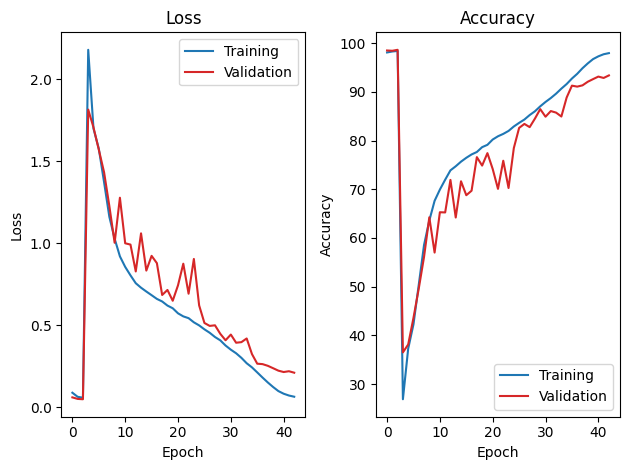

In [26]:
plot_loss_accuracy(
        train_loss_history, train_acc_history,
        val_loss_history, val_acc_history,
        filename=plot_file
)   

### Model Testing

Evaluating: 100%|██████████| 157/157 [00:02<00:00, 58.61it/s]


Test Accuracy: 91.77% | Loss: 0.3288
Confusion matrix saved to ./results/confusion_matrix-1.png


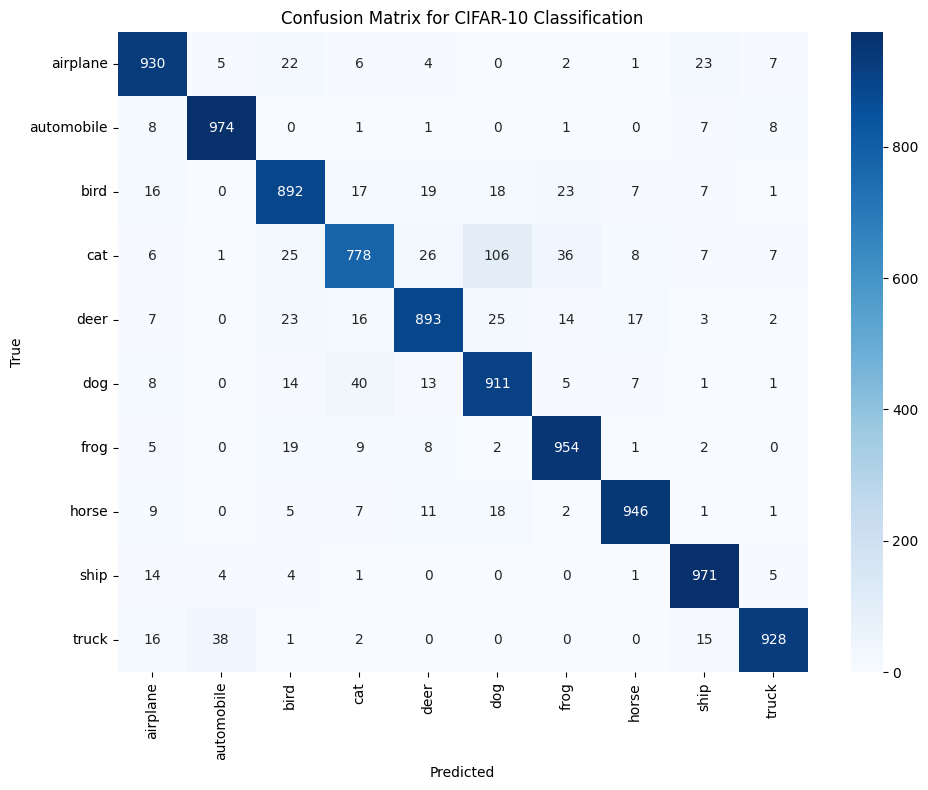

In [ ]:
if __name__ == "__main__":

    ##### YOUR CODE HERE #####
    # Implement your criterion
    criterion = nn.CrossEntropyLoss()

    model = resnet50_cifar10().to(DEFAULT_DEVICE)
    model = load_model(model, "./weights/best_resnet50_cifar10.pt", verbose=False)
    avg_loss, test_acc, conf_matrix = evaluate(model, test_loader, criterion)
    print(f"Test Accuracy: {test_acc:.2f}% | Loss: {avg_loss:.4f}")
    plot_confusion_matrix(conf_matrix, filename="./results/confusion_matrix.png")

## Post-Training Quantization (PTQ)
### Implement Quantization Function

In [20]:
class CusQuantObserver(tq.MinMaxObserver):
    """
    Observer module for your customized customize quantization scheme.
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        ##### YOUR CODE HERE #####
        # shift = round(math.log2(scale)) if scale > 0 else 0
        # shift = max(-max_shift_amount, min(max_shift_amount, shift))
        # approx_scale = 2.0 ** shift
        # return approx_scale
    
        # if scale <= 0:
        #     return float(scale)
        # shift = round(math.log2(scale))
        # shift = max(-max_shift_amount, min(max_shift_amount, shift))
        # approx_scale = 2.0 ** shift
        return 2**-(round(min(max(-math.log2(scale), 0), max_shift_amount)))


    def calculate_qparams(self):
        """Calculates the quantization parameters with scale."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        ##### YOUR CODE HERE #####
        # if min_val == max_val:
        #     if min_val == 0.0:
        #         min_val, max_val = -0.5, 0.5
        # else:
        #     min_val = min_val - abs(min_val) * 0.01
        #     max_val = max_val + abs(max_val) * 0.01

        # qmin, qmax = 0, 255  # 8-bit quantization range
        # scale = (max_val - min_val) / float(qmax - qmin)
        # if scale == 0:
        #     scale = 1.0e-6
        
        # zero_point = qmin - round(min_val / scale)
        # zero_point = max(qmin, min(qmax, zero_point))
        if self.qscheme == torch.per_tensor_symmetric:
            scale = (2 * max(abs(min_val), abs(max_val))) / ((2**8) - 1)
            if self.dtype == torch.qint8:
                zero_point = 0
            else:
                zero_point = 128
        else:
            scale = (max_val - min_val) / ((2**8) - 1)
            zero_point = -(round(min_val / scale))

        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=CustomQConfig"


class CustomQConfig(Enum):
    CusQuant = tq.QConfig(
        activation=CusQuantObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=CusQuantObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
        # weight = tq.default_per_channel_weight_observer
    )
    DEFAULT = None

### Evaluate Quantized Model

In [31]:
def test_performance(model_fp32, model_int8, dataloader, criterion,
                     is_ptq: bool = True,
                     fp32_file="./weights/best_resnet50_cifar10.pt",
                     int8_file="./weights/PTQ_resnet50_cifar10.pt"
                    ):
    
    device_fp32 = "cuda" if torch.cuda.is_available() else  'cpu'
    device_int8 =  'cpu'

    model_fp32.to(device_fp32)
    model_int8.to(device_int8)


    # ----- Test accuracy & loss -----
    print("Evaluating FP32 model...")
    loss_fp32, acc_fp32, _ = evaluate(model_fp32, dataloader, criterion, device=device_fp32)
    print(f"[FP32] Loss: {loss_fp32:.4f}, Accuracy: {acc_fp32:.2f}%")

    print("Evaluating INT8 model...")
    loss_int8, acc_int8, _ = evaluate(model_int8, dataloader, criterion, device=device_int8)
    if is_ptq:
        print(f"[PTQ INT8] Loss: {loss_int8:.4f}, Accuracy: {acc_int8:.2f}%")
    else:
        print(f"[QAT INT8] Loss: {loss_int8:.4f}, Accuracy: {acc_int8:.2f}%")


    # ----- Test latency -----
    model_fp32.to('cpu')
    dummy_input = torch.randn(1, 3, 32, 32).to('cpu')

    # FP32
    t0 = time.time()
    with torch.no_grad():
        for _ in range(1000):
            _ = model_fp32(dummy_input)
    t1 = time.time()
    fp32_time = (t1 - t0) / 1000

    # INT8
    t0 = time.time()
    with torch.no_grad():
        for _ in range(1000):
            _ = model_int8(dummy_input)
    t1 = time.time()
    int8_time = (t1 - t0) / 1000

    if is_ptq:
        print(f"[Latency] FP32: {fp32_time*1000:.3f} ms | PTQ INT8: {int8_time*1000:.3f} ms")
    else:
        print(f"[Latency] FP32: {fp32_time*1000:.3f} ms | QAT INT8: {int8_time*1000:.3f} ms")
    print(f"[Speedup] ~{fp32_time/int8_time:.2f}x faster")


    # ----- Compare file size ----- 
    if os.path.exists(fp32_file) and os.path.exists(int8_file):
        size_fp32 = os.path.getsize(fp32_file) / 1e6
        size_int8 = os.path.getsize(int8_file) / 1e6
        if is_ptq:
            print(f"[File size] FP32: {size_fp32:.2f} MB | PTQ INT8: {size_int8:.2f} MB")
        else:
            print(f"[File size] FP32: {size_fp32:.2f} MB | QAT INT8: {size_int8:.2f} MB")
        print(f"[Compression] ~{size_fp32/size_int8:.2f}x smaller")
    else:
        print("Warning: model files not found. Skipping file size comparison.")

### Run PTQ Workflow

In [29]:
def calibrate(model, loader, device= 'cpu'):
    """
    Run one pass of calibration on the dataset to collect statistics 
    for quantization (e.g., min/max values of activations).
    
    Args:
        model (nn.Module): The model prepared for quantization.
        loader (DataLoader): Data loader for calibration dataset.
        device (str): Device to run calibration on.
    """
    ##### YOUR CODE HERE #####
    model.eval().to(device)  
    with torch.no_grad(): 
        for x, _ in loader:       
            model(x.to(device))


def ptq_quantization():
    """
    Perform Post-Training Quantization (PTQ) on the trained ResNet-50 model.
    
    Steps:
        1. Load CIFAR-10 validation set
        2. Load trained FP32 model
        3. Fuse model layers
        4. Prepare model for PTQ
        5. Calibrate using validation data
        6. Convert model to INT8
        7. Save quantized model
    Returns:
        model_int8 (nn.Module): The INT8 quantized model after PTQ
    """
    # 1. Data
    _, val_loader, _ = get_cifar10_loaders(batch_size=64)

    # 2. Load model (FP32 baseline)
    fp32_checkpoint = "./weights/best_resnet50_cifar10.pt"
    model_fp32 = load_model(resnet50_cifar10(), fp32_checkpoint)

    ##### YOUR CODE HERE #####
    # 3. Fuse layers
    model_fp32.eval().to('cpu')
    model_fp32.fuse_model()

    # 4. Prepare PTQ
    # custom_qconfig = tq.QConfig(
    #     activation=CusQuantObserver.with_args(dtype=torch.quint8, qscheme=torch.per_tensor_affine),
    #     weight=tq.default_per_channel_weight_observer
    # )
    custom_qconfig = CustomQConfig.CusQuant.value
    model_fp32.qconfig = custom_qconfig
    # model_fp32.qconfig = tq.get_default_qconfig(torch.backends.quantized.engine)
    model_prepared = tq.prepare(model_fp32, inplace=False)

    # 5. Calibrate
    calibrate(model_prepared, val_loader)

    # 6. Convert to INT8
    model_int8 = tq.convert(model_prepared, inplace=False)

    # 7. Save INT8 model
    save_model(model_int8, "./weights/PTQ_resnet50_cifar10.pt", existed="overwrite")
    
    return model_int8

### Compare FP32 vs Quantized Results

In [30]:
if __name__ == "__main__":
    model_int8 = ptq_quantization()

    ##### YOUR CODE HERE #####
    # Implement your criterion
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion = nn.CrossEntropyLoss()

    fp32_checkpoint = "./weights/best_resnet50_cifar10.pt"
    model_baseline = load_model(resnet50_cifar10(), fp32_checkpoint, verbose=True)
    test_performance(model_baseline, model_int8, test_loader, criterion, is_ptq=True)

Model loaded from ./weights/best_resnet50_cifar10.pt (94.408403 MB)
Model saved at ./weights/PTQ_resnet50_cifar10.pt (23.661131 MB)
Model loaded from ./weights/best_resnet50_cifar10.pt (94.408403 MB)
Evaluating FP32 model...


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 62.98it/s]


[FP32] Loss: 0.2297, Accuracy: 92.72%
Evaluating INT8 model...


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 23.99it/s]


[PTQ INT8] Loss: 0.2422, Accuracy: 92.37%
[Latency] FP32: 9.761 ms | PTQ INT8: 3.036 ms
[Speedup] ~3.21x faster
[File size] FP32: 94.41 MB | PTQ INT8: 23.66 MB
[Compression] ~3.99x smaller


## Quantization-Aware Training (QAT)
### Run QAT Workflow

In [32]:
def qat_quantization():
    """
    Run Quantization-Aware Training (QAT) workflow on ResNet-50 for CIFAR-10.
    
    Steps:
        0. Prepare CIFAR-10 dataloaders
        1. Load pretrained FP32 model
        2. Fuse model layers
        3. Assign QAT qconfig
        4. Prepare model for QAT
        5. Train with QAT
        6. Convert to INT8 model
        7. Save quantized model
    Returns:
        model_int8 (nn.Module): The INT8 quantized model after QAT
    """
    # 1. Data
    # train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=64)

    # 2. Load model (FP32 baseline)
    fp32_checkpoint = "./weights/best_resnet50_cifar10.pt"
    model_fp32 = load_model(resnet50_cifar10(), fp32_checkpoint)

    ##### YOUR CODE HERE #####
    # 3. Fuse layers before QAT
    model_fp32.eval()
    model_fp32.cpu()
    model_fp32.fuse_model()

    # model_fp32.to("cuda")
    model_fp32.train()

    # 4. Set qconfig to enable QAT
    # custom_qconfig = tq.QConfig(
    #     activation=CusQuantObserver.with_args(dtype=torch.quint8, qscheme=torch.per_tensor_affine),
    #     weight=tq.default_per_channel_weight_observer
    # )
    custom_qconfig = CustomQConfig.CusQuant.value
    model_fp32.qconfig = custom_qconfig
    # model_fp32.qconfig = tq.get_default_qat_qconfig(torch.backends.quantized.engine)
    
    # 5. Prepare model
    model_qat = tq.prepare_qat(model_fp32, inplace=True)
    model_qat = model_qat.to("cuda")

    # 6. Run QAT training
    # Use train_model(is_qat=True, ...)
    model_qat = train_model(
        model=model_qat,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=3,
        warmup_epochs=1,
        lr=1e-4,
        is_qat=True
    )
    
    # 7. Convert to INT8
    model_qat.cpu()
    model_qat.eval()
    model_int8 = tq.convert(model_qat, inplace=False)

    # 8. Save INT8 model
    save_model(model_int8, "./weights/QAT_resnet50_cifar10.pt", existed="overwrite")

    return model_int8

if __name__ == "__main__":
    model_int8 = qat_quantization()

    ##### YOUR CODE HERE #####
    # Implement your criterion
    criterion = nn.CrossEntropyLoss()

    # train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=128)
    fp32_checkpoint = "./weights/best_resnet50_cifar10.pt"
    model_baseline = load_model(resnet50_cifar10(), fp32_checkpoint, verbose=False)
    test_performance(model_baseline, model_int8, test_loader, criterion, is_ptq=False,
                    fp32_file=fp32_checkpoint, int8_file="./weights/QAT_resnet50_cifar10.pt")

Model loaded from ./weights/best_resnet50_cifar10.pt (94.408403 MB)
plot_file:  ./results/QAT_loss_accuracy.png


100%|██████████| 79/79 [00:01<00:00, 42.80it/s]


Epoch 1 | Train Loss: 0.0620 | Train Acc: 98.12% | Val Loss: 0.0650 | Val Acc: 97.92%
Model saved at ./weights/QAT_resnet50_cifar10.pt (94.152398 MB)


100%|██████████| 79/79 [00:01<00:00, 42.99it/s]


Epoch 2 | Train Loss: 0.0633 | Train Acc: 98.00% | Val Loss: 0.0642 | Val Acc: 98.12%
Model saved at ./weights/QAT_resnet50_cifar10.pt (94.152398 MB)


100%|██████████| 79/79 [00:01<00:00, 42.04it/s]


Epoch 3 | Train Loss: 0.0604 | Train Acc: 98.12% | Val Loss: 0.0584 | Val Acc: 98.02%
Model saved at ./weights/QAT_resnet50_cifar10.pt (23.661131 MB)
Evaluating FP32 model...


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 58.29it/s]


[FP32] Loss: 0.2297, Accuracy: 92.72%
Evaluating INT8 model...


Evaluating: 100%|██████████| 157/157 [00:07<00:00, 21.82it/s]


[QAT INT8] Loss: 0.2531, Accuracy: 92.15%
[Latency] FP32: 9.765 ms | QAT INT8: 3.119 ms
[Speedup] ~3.13x faster
[File size] FP32: 94.41 MB | QAT INT8: 23.66 MB
[Compression] ~3.99x smaller
